# Week 3 – CNN Embeddings on Vehicle Damage Images

## Objective
Learn how Convolutional Neural Networks automatically learn
useful representations from vehicle damage images.


In [2]:
# TODO: Import required libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


c:\Users\vardh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Step 1: Load and Preprocess Dataset


In [4]:
# TODO: Load vehicle damage images
# Resize images (e.g., 128x128)
# Normalize pixel values
import json

with open("annotations.json", "r") as f:
    data = json.load(f)

# Build class mapping
all_classes = set()
for info in data.values():
    for r in info["regions"]:
        all_classes.add(r["class"])

class_names = sorted(all_classes)
class_to_idx = {c: i for i, c in enumerate(class_names)}

X = []
y = []

for img_name, info in data.items():
    img_path = os.path.join("archive/image/image/", img_name)

    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0  

    label = info["regions"][0]["class"]  

    X.append(img)
    y.append(class_to_idx[label])


## Step 2: Define CNN Architecture
Build a small CNN to learn image features.


In [12]:
# TODO: Define a simple CNN
# Conv -> ReLU -> Pool -> Conv -> Pool -> Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dense(len(all_classes), activation="softmax")
])
import numpy as np

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)


## Step 3: Train the CNN
This step will take time

In [14]:
# TODO: Compile and train the CNN model
# Keep training short (few epochs)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First y:", y[0])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X,
    y,
    epochs=5,
    batch_size=32,
    shuffle=True
)


X shape: (11621, 128, 128, 3)
y shape: (11621,)
First y: 1.0
Epoch 1/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 91s 245ms/step - accuracy: 0.3086 - loss: 1.7980
Epoch 2/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 78s 215ms/step - accuracy: 0.4312 - loss: 1.5116
Epoch 3/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 63s 172ms/step - accuracy: 0.5733 - loss: 1.1643
Epoch 4/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 61s 168ms/step - accuracy: 0.7915 - loss: 0.6068
Epoch 5/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 61s 166ms/step - accuracy: 0.9419 - loss: 0.2025


## Step 4: Extract CNN Embeddings
Extract features from the penultimate layer.


In [17]:
from tensorflow.keras.models import Model

embedding_model = Model(
    inputs=model.inputs,
    outputs=model.layers[-2].output
)

embeddings = embedding_model.predict(X)


364/364 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step


## Step 5: PCA / t-SNE on CNN Embeddings
Visualize learned representations.


In [18]:
# TODO: Apply PCA or t-SNE to CNN embeddings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Reduce first for stability
pca_50 = PCA(n_components=50, random_state=42)
emb_50 = pca_50.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_tsne = tsne.fit_transform(emb_50)


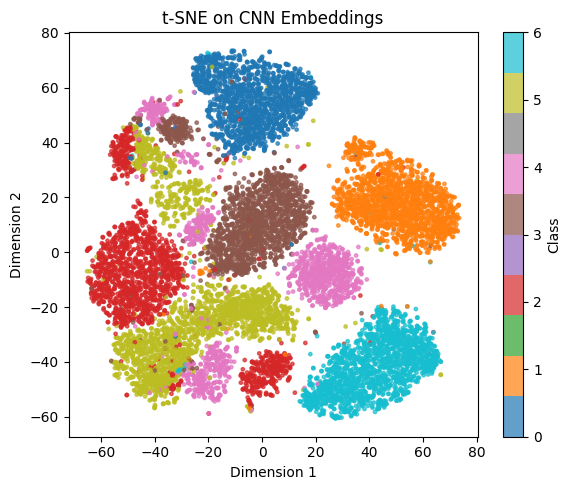

In [19]:
plt.figure(figsize=(6, 5))
plt.scatter(
    emb_tsne[:, 0],
    emb_tsne[:, 1],
    c=y,
    s=6,
    cmap="tab10",
    alpha=0.7
)
plt.colorbar(label="Class")
plt.title("t-SNE on CNN Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()

## Reflection
- How do CNN embeddings differ from HOG features?
- Why do CNN features work better for damage detection?
